<a href="https://colab.research.google.com/github/PyDataCalgary/pydata-calgary/blob/master/Bayesian_Methods_101/Intro_to_Bayesian_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyData Calgary Bayesian Series: Intro to Bayesian Inference

In the last installment, we refreshed our understanding of basic probability concepts and even derived Bayes theorem by working through the intuitions surrounding the general multiplication of probability. 

In this session, we will flesh out our understanding of Bayesian inference, break down and establish our intuition around Bayes theorem, and begin to establish a contextualization for where Bayesian inference fits into the data scientists toolkit. 

In this notebook, we will review the following concepts:

 - Data Generation Process
   - Generative vs Discriminative Modelling
 - Frequentist vs Bayesian Worldview
 - Decomposition of Bayes Theorem
   - Likelihood
   - Prior
   - Posterior
 - The problem of the denominator - why we need computational methods

This notebook will borrow heavily from the first three references - Cam Davidson's Bayesian Methods for Hackers[1], the PyMC3 documentation, and Ben Lambert's A Student's Guide to Bayesian Statistics

## Preamble: The Underrated Data Generation Process or Why Should I Care? A Rant

In the Book of Why by Judea Pearl, Pearl (winner of the Turing Award for fundamental advancements in AI) argues there are three levels of causation which strarify intelligent systems: reasoning by association, intervention, and counterfactuals, given below. The lowest level of reasoning is asking "what if I see X?". It employs no understanding of causation or the underlying mechansisms which drive the occurence of X. The system simply looks at the associations between obersvations, and returns what it has seen before. Intervention asks "what happens to X if I do y?", and counterfactuals probe "what would have happened to X if I had done y' instead of y?". 

![causation.jpg](https://drive.google.com/uc?id=1VddHsTqhIOKiEsJ_0esKhkndGWvmrIMP)

In most applications, modern AI still sits at the lowest rung in the ladder of causation - reasoning by association. Deep learning helps us to see in higher dimensions, but at the end of the day it has no insight into the true nature of the systems it models. Despite it's ability to model complex systems, it has only marginal utility in helping humans to decipher the true nature of said systems. It is for this reason that we call it a "black box", and it is for this reason that by and large, deep learning adoption industry can slow and often disappointing to those of us in the field.

This isn't to say that deep learning and other popular algorithms don't have incredible merit. My point is that many of us are familiar with the unsatisfied reactions and hesitations from leadership when asked to explain your model. And yes, this is even after implementing all the tools in the model explainability toolkit. It's just hard to apply the logic of causality - which decision makers look for - to the associative rules learned through ML algos.

Amongst techincal professionals, the weakness of interpretability is often handwaved away by a "get with the times" attitude. I will not dedicate time here to argue the point, more than to say "if it's important to decision makers it should be important to us." 

Where do we go from here? We can use our human reasoning to bake in our own causal understanding of the underlying system into our models. We do this by by telling a story about the data and specifying the *Data Generation Process (DGP)*. Specifying the DGP is the difference between giving the answer to a homework question and showing your work. When you simply give an answer, we can only trust how often you've gotten the answer right in the past. We have no other way of knowing if you're right, slightly wrong, or out to lunch. By showing your work with a data generation process, you allow others to evaluate your process, judge it, critique it, and improve it. By showing your work, you're transparent in your insight, fostering trust and building understanding. 

The DGP (and generative modelling in general) is often neglected in many of the pop datasci articles published on mediums like Towards Data Science. However, it has never been neglected from statistics. In my optinion, even humble linear regression involves specifying the DGP. Specifically, we say "Our explanatory variables X are causally or confoundedly related to y through a linear transformation and some error term $\epsilon$ which is normally distributed." The iid assumption is another part of the data generation process and specifies the constraints. 

Specifying a data generation process is telling the story of your data. Where it came from and how it got there. 

I view specifying the DGP as helping to move our models up one rung on the ladder of causality through a man-machine symbiosis. The human specifies the underlying process via first-principles reasoning and domain expertise. The machine (our magical inference button via MCMC in this course, though can also be frequentist methods, VI, etc) helps us to use computational tools to fit the paramaeters and check the validity of our assumptions.

When the executive comes back asking why your model recommended a large resource investment in a risky venture, it sure feels a lot better to be able to give a well articulated reason the CXO can understand rather than throwing up your hands, exclaiming "BECAUSE MATH!" as you wonder why these luddites can't recognize your model's brilliance. At the end of the day, building predictive models is only a small piece of the data scientist's value add; it's the Kaggle piece, the Towards Data Science piece. The rest of the value add is about extracting understanding and knowledge from your organizations data. Generating insights. Learning and sharing. 

#### The Hard Thing about Hard Things

You may be saying to yourself - sure, I agreee; this all sounds great. So why doesn't everyone do it all the time? Unfortunately, it's because it's hard. You can train an xgboost algo in a few lines of code. It doesn't require deep understanding of the features. It doesn't require insight about where the data came from or what the data means. You can copy-paste the workflow to new problems (ever notice how most Kaggle notebooks feel the exact same?)

Coming up with a data generation process, however, does require understanding. It requires you to hypothesize about what is *causing* X to occur, and then to test that hypothesis. It requires you to think about the next rung on the ladder of causation - not to just fit the data, but to understand it.

Through the rest of this series, we will focus on ways that we can use our strength as humans to reason about causality and the underlying determining factors to work in conjunction with our technical tools. Our technical tools will augment and strengthen our reasoning to allow us to provide not only predictions, but insights as well. 

#### Data Generation Process and Generative vs Discriminative Models

What is a data generation process? A data generation process is a story. As mentioned, linear regression is a data generation process - we imagine that our explanatory variables are nudging our dependent variable in one direction or another, and by counting up all these nudges we can estimate our variable of interest. 

Let's borrow a simple example directly from Bayesian Methods for Hackers. We have a count of the number of text messages received per day:


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline
pylab.rcParams['figure.figsize'] = (12,6)
sns.set()

Populating the interactive namespace from numpy and matplotlib


In [2]:
count_data = np.loadtxt("txtdata.csv")
n_count_data = len(count_data)
plt.bar(np.arange(n_count_data), count_data, color="#348ABD")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Did the user's texting habits change over time?")
plt.xlim(0, n_count_data);

OSError: ignored

Looking at this data, we may hypothesize that at some point in time, the rate at which the author recieved text messages changed. The story goes something like this: "I receive on average X text messages per day. There is a decent amount of variability, but I think it centers around some constant value. Then at some point in this sample, something changed in my life, and the rate at which I received text messages changed."  

You may want to ask questions, such as "how likely is it that this story is true?" and "if it is true, when did the change occur? And by how much?". These are questions which are very difficult to ask of a prescriptive model. Take a minute and think about how you might try to implement a tree based or NN algorithm to answer these questions (especially given the small dataset). It's not impossible, but it certainly isn't intuitive. We'll reference back to this dataset (readers are referred to chapter 1 of Bayesian Methods for Hackers for the full breakdown).

#### Generative vs Discriminative Modelling

The DGP is deeply related to the difference between Generative and Discriminative modelling. In short, generative modelling learns the joint distrution $P(X,y)$ and discriminative modelling learns the boundaries between classes $P(y|X)$. Generative models predict conditional probabilities for discriminative tasks through Bayes theorem, giving them more flexibility. 

Taking inspiration from [this medium article](https://medium.com/@mlengineer/generative-and-discriminative-models-af5637a66a3), let's give a story to develop our intuition.

There are two building inspectors, the Alan and Barry. Alan learns the engineering and safety reasons behind the regulations, building up an understanding in his head as to why the regulations help make a building safe. He uses his information about the regulations to create a model in his head about what makes a building safe. 

Barry, on the other hand, simply states "I don't need to know why the regulations are what they are, so long as I have the regulations I can label a building as safe or unsafe." He carries a copy of the regulations with him, and cross references what he sees in his inspections against the regulations.

Now, both inspectors can accomplish their tasks sufficiently. In fact, in many cases, we can imagine that Barry would do a better a job, since all he needs to focus on is the rulebook. Alan also needs to think through the "why" which leaves room for error.

However, what if we were to ask the two inspectors to actually *build* a safe deck? Or inspect a type of building for which they haven't seen the regulations yet? Which would you trust? Or, if we asked them to explain why the structure was given an unsafe grade and what we could do to improve? Clearly, Alan would be the better choice.

In this example, Alan builds up a **generative** model in his head, while Barry uses a **discriminative** model. Mathematically speaking, both are tasked with learning $f X \mapsto y$ where X is the constructed structure and y is the classification for passing/failing the inspection. 

Alan learns what makes a building is safe, $P(y)$ and how the regulations describe a safe building $P(X|y)$. To classify the building as safe or unsafe, he uses Bayes theorem (without calling it that) to estimate if the building should pass inspection $P(y|X)$. In words, he is saying "if I know what makes a building safe and which practices are associated with saf construction, how likely is this building safe given the evidence I've observed?" Barry on the other hand simply learns directly how to estimate $P(y|X)$ directly from the regulations. 


Summing this using classification tasks,

##### Generative classifiers
 1. Assume some functional form for $P(y)$, $P(X|y)$
 2. Estimate parameters of $P(X|y)$, $P(y)$ from the evidence (training data)
 3. Use Bayes rule to calculate $P(y|X)$
 
##### Discriminative Classifiers
 1. Assume some functional form for $P(Y|X)$
 2. Estimate parameters of $P(Y|X)$ directly from training data

[From google](https://developers.google.com/machine-learning/gan/generative): Discriminative models try to draw boundaries in the data space, while generative models try to model how data is placed throughout the space. For example, the following diagram shows discriminative and generative models of handwritten digits:

![image](https://drive.google.com/uc?id=1eHVbxRcb0ARnz888PfnQazZNwEOJJX6X)

Examples:

**Generative classifiers**
 - Naïve Bayes
 - Bayesian networks
 - Hidden Markov Models (HMM)
 
**Discriminative Classifiers**
 - Logistic regression
 - Support Vector Machines
 - Most neural networks
 
Since generative models involve parameterizing two unknown distributions, $P(y)$ and $P(X|y)$, it's unsurprising that in terms of raw accuracy, it will underperform discriminative models which only need to parameterize $P(y|X)$. In exchange for this reduced accuracy at modelling $P(y|X)$, we are able to draw possible samples from the joint probability distribution $P(X, y)$ and surround our estimates with uncertainty estimates and probabilities.



### Concrete Example

Let's turn back to the text message example above to tell the story with a data generation process. We refer the reader to the [relevant chapter in Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_PyMC3.ipynb) for the full derivation which goes through each step in detail. We provide an abridged version below.

We know from the steps laid out for generative models, we need to define P(y) and P(X|y). Our explanatory variables in this case are the timestamp, since we're looking to evaluate how the count of texts changes over time. First, we model P(y). The distribution of choice for measuring counts over time is the Poisson distribution. So, we say that our count of text messages, P(y), comes from a Poisson distribution

$$ C_i \sim \text{Poisson}(\lambda)  $$

The poisson distribution is parameterized by $\lambda$, which represents how *often* the underlying event occurs, where higher lambdas mean the event occurs less frequently. This leaves us with estimating $\lamdba$, which can be seen as modelling $P(X|y)$; how does $\lambda$ change as a function of time, and what do we expect $\lambda$ to be, given the count data we have observed?

We break our DGP down into steps:
1. The count of text messages is determined by some underlying rate, $\lambda$
2. This rate changes from $\lambda_1$ to $\lambda_2$
3. The rate change occurs discretely, jumping directly from $\lambda_1$ to $\lambda_2$ at some time $t=\tau$

Note that we have to make assumptions when building a generative model. We could have used a linear evolution from $\lambda_1$ to $\lambda_2$ and it would have been equally valid. This is what makes generative modelling hard - we must make and justify choices about the underlying process. This is also why I view this brand of generative models as higher on the ladder of causality - we use our human reasoning to specify the causal forces, that there was some event which occured causing a discrete jump in the underlying rate at which text messages are generated.

Translating our steps above into the language of math (our intermediary language before specifying the model in code):

$$ C_i \sim \text{Poisson}(\lambda)  $$

$$
\lambda = 
\begin{cases}
\lambda_1  & \text{if } t \lt \tau \cr
\lambda_2 & \text{if } t \ge \tau
\end{cases}
$$

Our data generation process has a couple more steps before we're done, and this will lead us down the path of Bayesian Inference. We've specified how the model generates data, but we are left with the task of estimating exactly *what* $\lambda_1, \lambda_2$ and $\tau$ are. We will make some educated guesses, known as our priors as to what these variables could be. We will discuss this concept in greater depth below, but in Bayesian statistics we represent our parameters as **distributions rather than point estimates.** That is, we think that the underlying rate at which text messages are received is better described as a range of value with probabilities rather than a single number. So, we take our guesses as to what the distributions are which describe $\lambda_1, \lambda_2$, and $\tau$, thereby defining our priors. It is enough to say that we will choose to characterize our $\lambda$s by exponential distributions and our $\tau$ by a uniform distribution. 

\begin{align}
&\lambda_1 \sim \text{Exp}( \alpha ) \\\
&\lambda_2 \sim \text{Exp}( \alpha ) \\\
&\tau \sim \text{DiscreteUniform(1,70) }
\end{align}

The poisson and exponential distributions are in the same family (the exponential distribution is the rate at which the events in a poisson process are generated), the exponential a good choice to model our guess for $\lambda$. $\alpha$ is called a *hyper-parameter* or *parent variable*. In literal terms, it is a parameter that influences other parameters. Our initial guess at $\alpha$ does not influence the model too strongly, so we have some flexibility in our choice.  A good rule of thumb is to set the exponential parameter equal to the inverse of the average of the count data. Since we're modeling $\lambda$ using an exponential distribution, we can use the properties of the poisson distribution to get:

$$\frac{1}{N}\sum_{i=0}^N \;C_i \approx E[\; \lambda \; |\; \alpha ] = \frac{1}{\alpha}$$ 

For $\tau$, we use the uniform distribution to basically throw up our hands and say "I don't know when it changed and every point is as likely as any other." We could have used other distributions, such as normal or beta; in this case it doesn't strongly influence the model.

### Putting it together in PyMC3

Without explaining the math and stats yet, we can put it all together and run the model in PyMC3. We'll explain how it all works, but first let's see it in action!

In [ ]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/count_data.mean()  # Recall count_data is the
                                   # variable that holds our txt counts
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=n_count_data - 1)
    
    # implement the switch from lambda 1 to lambda 2
    idx = np.arange(n_count_data) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)
    
    # here is where we 'fit' the model to the training data, by setting observed to our count_data
    observation = pm.Poisson("obs", lambda_, observed=count_data)

with model:
    trace = pm.sample(10000, tune=5000)

Sequential sampling (2 chains in 1 job)
CompoundStep
>NUTS: [lambda_2, lambda_1]
>Metropolis: [tau]
Sampling chain 1, 0 divergences: 100%|██████████| 15000/15000 [00:15<00:00, 952.78it/s]
The number of effective samples is smaller than 25% for some parameters.


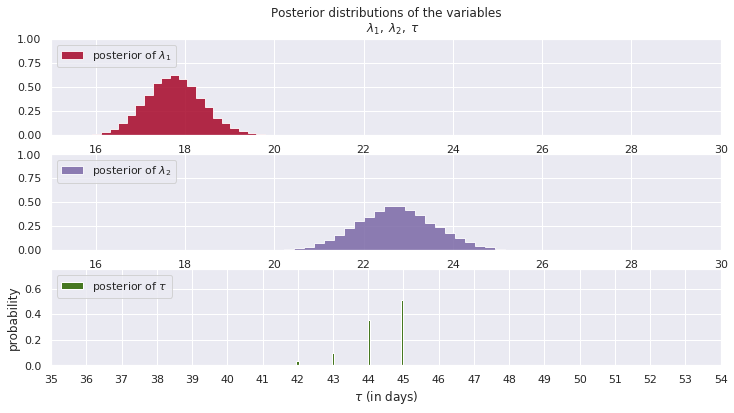

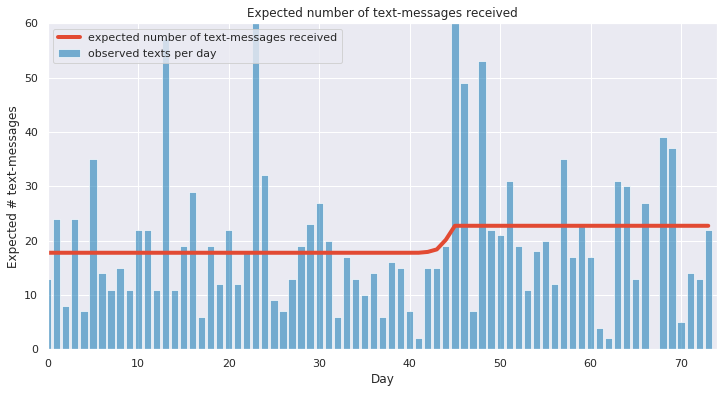

In [ ]:
lambda_1_samples = trace['lambda_1']
lambda_2_samples = trace['lambda_2']
tau_samples = trace['tau']

#histogram of the samples:

ax = plt.subplot(311)
ax.set_autoscaley_on(False)

plt.hist(lambda_1_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_1$", color="#A60628", density=True)
plt.legend(loc="upper left")
plt.title(r"""Posterior distributions of the variables
    $\lambda_1,\;\lambda_2,\;\tau$""")
plt.xlim([15, 30])
plt.xlabel("$\lambda_1$ value")

ax = plt.subplot(312)
ax.set_autoscaley_on(False)
plt.hist(lambda_2_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="posterior of $\lambda_2$", color="#7A68A6", density=True)
plt.legend(loc="upper left")
plt.xlim([15, 30])
plt.xlabel("$\lambda_2$ value")

plt.subplot(313)
w = 1.0 / tau_samples.shape[0] * np.ones_like(tau_samples)
plt.hist(tau_samples, bins=n_count_data, alpha=1,
         label=r"posterior of $\tau$",
         color="#467821", weights=w, rwidth=2.)
plt.xticks(np.arange(n_count_data))

plt.legend(loc="upper left")
plt.ylim([0, .75])
plt.xlim([35, len(count_data)-20])
plt.xlabel(r"$\tau$ (in days)")
plt.ylabel("probability");

plt.show();

# tau_samples, lambda_1_samples, lambda_2_samples contain
# N samples from the corresponding posterior distribution
N = tau_samples.shape[0]
expected_texts_per_day = np.zeros(n_count_data)
for day in range(0, n_count_data):
    # ix is a bool index of all tau samples corresponding to
    # the switchpoint occurring prior to value of 'day'
    ix = day < tau_samples
    # Each posterior sample corresponds to a value for tau.
    # for each day, that value of tau indicates whether we're "before"
    # (in the lambda1 "regime") or
    #  "after" (in the lambda2 "regime") the switchpoint.
    # by taking the posterior sample of lambda1/2 accordingly, we can average
    # over all samples to get an expected value for lambda on that day.
    # As explained, the "message count" random variable is Poisson distributed,
    # and therefore lambda (the poisson parameter) is the expected value of
    # "message count".
    expected_texts_per_day[day] = (lambda_1_samples[ix].sum()
                                   + lambda_2_samples[~ix].sum()) / N


plt.plot(range(n_count_data), expected_texts_per_day, lw=4, color="#E24A33",
         label="expected number of text-messages received")
plt.xlim(0, n_count_data)
plt.xlabel("Day")
plt.ylabel("Expected # text-messages")
plt.title("Expected number of text-messages received")
plt.ylim(0, 60)
plt.bar(np.arange(len(count_data)), count_data, color="#348ABD", alpha=0.65,
        label="observed texts per day")

plt.legend(loc="upper left");

### Interpretation

Recall that Bayesian methodology returns a *distribution*, since we model our parameters as ranges of possible values with probabilties. Hence we now have distributions to describe the unknown $\lambda$s and $\tau$. What have we gained? Immediately, we can see the uncertainty in our estimates: the wider the distribution, the less certain our posterior belief should be. We can also see what the plausible values for the parameters are: $\lambda_1$ is around 18 and $\lambda_2$ is around 23. The posterior distributions of the two $\lambda$s are clearly distinct, indicating that it is indeed likely that there was a change in the user's text-message behaviour.

Notice also that the posterior distributions for the $\lambda$s do not look like exponential distributions, even though our priors for these variables were exponential. In fact, the posterior distributions are not really of any form that we recognize from the original model. But that's OK! This is one of the benefits of taking a computational point of view. If we had instead done this analysis using mathematical approaches, we would have been stuck with an analytically intractable (and messy) distribution. Our use of a computational approach makes us indifferent to mathematical tractability.

Our analysis also returned a distribution for $\tau$. Its posterior distribution looks a little different from the other two because it is a discrete random variable, so it doesn't assign probabilities to intervals. We can see that near day 45, there was a 50% chance that the user's behaviour changed. Had no change occurred, or had the change been gradual over time, the posterior distribution of $\tau$ would have been more spread out, reflecting that many days were plausible candidates for $\tau$. By contrast, in the actual results we see that only three or four days make any sense as potential transition points. 

### The Engine: Bayesian Inference

To understand how the magic above works, we must first understand the Bayesian state of mind and how it differs from the traditional frequentist statistics. Keynes famously quipped "When the facts change, I change my mind. What do you do sir?" This quote explains the Bayesian point of view better than any long winded explanation I could provide. It is about coming in with your preexisting knowledge and beliefs about the world (the prior), observing some new evidence (the likelihood), and combining the two to create an updated belief about the world (the posterior).

**Frequentist (Classical) Statistics**
- Probabilities are long term average frequencies
- Nature has a true underlying parameter which lines up with our models; we observe data to try and 
- Produces point estimates through eg maximum likelihood estimation. 
    - Eg, "What is the mean height of aboriginal australians?" returns a single number based on what the *most likely* mean height is
- "I know that there is an underlying distribution to this data, but I don’t know what it is. I’ll observe events, and then determine the most likely settings after having seen the data"

**Bayesian Statistics**
- Probabilities are degrees of belief about a parameter
- Our models are always wrong and can only *approximate* Nature. As such, Nature does not have a true underlying parameter which can be observed. Instead, it has a range of plausible parameters which let our models describe her, with varying degrees of plausibility.
- Produces estimates as distributions
  - Eg "What is the mean height of aboriginal australians?" returns a distribution of *plausible* means, with the mode of the distribution being equal to what the most likely mean height is.
  - Note the difference between frequentist and bayesian statistics. The Bayesian version natively incorporates uncertainty into our models, but we can always convert from a Bayesian estimate to a frequentist estimate (but not vice versa)
- "I have a hypothesis about how the world works. I observe some new evidence which is potentially at odds with my model. Should I update my beliefs?"

Let's ask for support from with another reference to Bayesian Methods explaining the Bayesian state of mind:

> Bayesian inference differs from more traditional statistical inference by preserving *uncertainty*. At first, this sounds like a bad statistical technique. Isn't statistics all about deriving *certainty* from randomness? To reconcile this, we need to start thinking like Bayesians. 

> The Bayesian world-view interprets probability as measure of *believability in an event*, that is, how confident we are in an event occurring. In fact, we will see in a moment that this is the natural interpretation of probability. 

> For this to be clearer, we consider an alternative interpretation of probability: *Frequentist*, known as the more *classical* version of statistics, assume that probability is the long-run frequency of events (hence the bestowed title). For example, the *probability of plane accidents* under a frequentist philosophy is interpreted as the *long-term frequency of plane accidents*. This makes logical sense for many probabilities of events, but becomes more difficult to understand when events have no long-term frequency of occurrences. Consider: we often assign probabilities to outcomes of presidential elections, but the election itself only happens once! Frequentists get around this by invoking alternative realities and saying across all these realities, the frequency of occurrences defines the probability. 

> Bayesians, on the other hand, have a more intuitive approach. Bayesians interpret a probability as measure of *belief*, or confidence, of an event occurring. Simply, a probability is a summary of an opinion. An individual who assigns a belief of 0 to an event has no confidence that the event will occur; conversely, assigning a belief of 1 implies that the individual is absolutely certain of an event occurring. Beliefs between 0 and 1 allow for weightings of other outcomes. This definition agrees with the probability of a plane accident example, for having observed the frequency of plane accidents, an individual's belief should be equal to that frequency, excluding any outside information. Similarly, under this definition of probability being equal to beliefs, it is meaningful to speak about probabilities (beliefs) of presidential election outcomes: how confident are you candidate *A* will win?

### The Core of the Engine: Breaking down Bayes Theorem

In our prior session, we derived Bayes theorem before we really understood what it meant or what it could do for us. Now, we've seen what it can do for us, but we don't really understand *how*. So, let's break down this pesky equation and really understand it. First, let's just work through a simple example. Recall

$$ P( A | B ) = \frac{ P(B | A) P(A) } {P(B) } $$

which we derived from the general multiplcation rule linking joint, conditional, and marginal probability distributions. Let's see it in action!

There is a rare genetic disorder which affects one in fifty thousand individuals. We have a lab test which will diagnose whether or not you have the disease. If you do have the disease, the test will return a positive result 99.5% of the time. If you don't have the disease, the test will correctly return a negative reading 99.99% of the time. We take the test and receive a positive result. What is the probability that we have the disease?

$$ P( \text{have disease} | \text{tested positive} ) = \frac{ P(\text{tested positive} | \text{have disease}) P(\text{have disease}) } {P(\text{tested positive}) } $$

$P(\text{have disease}) = \frac{1}{50000}$

$P(\text{tested positive}|\text{have disease}) = 0.995$

$P(\text{tested positive}) = P(\text{true positive}) + P(\text{false postive}) = (\frac{1}{50000} * 0.995) + (1 - \frac{1}{50000}) * 0.0001$

$P(\text{have disease}|\text{tested positive}) = ?$

In [ ]:
# Step 1: Calculate using Bayes theorem
p_have_disease = 1/50000
p_true_positive = 0.995
p_false_negative = 0.0001
p_tested_positive = p_have_disease * p_true_positive + (1-p_have_disease) * p_false_negative

def bayes(p_b_giv_a, p_a, p_b):
    return p_b_giv_a * p_a / p_b

p_disease_giv_positive = bayes(p_true_positive, p_have_disease, p_tested_positive) * 100
print('Probability you have the disease: ', round(p_disease_giv_positive, 1), '%')

Probability you have the disease:  16.6 %


For most of us, this is a counterintuitive result considering a very accurate test! This highlights one of the uses of Bayes rule - helping our animal brains process probabilities, which we are often bad at when given in terms of pure numbers. The results are much more intuitive when we run a simulation:

In [ ]:
# Step 2: Verify our results computationally

n = 1000000

n_users = np.random.binomial(n,p_have_disease)
print('number of people with disease: {}'.format(n_users))
n_pos_users = np.random.binomial(n_users,p_true_positive)
print('number of true positives: {}'.format(n_pos_users))
n_pos_nonusers = np.random.binomial(n-n_users,p_false_negative)
print('number of false positives: {}'.format(n_pos_nonusers))
p_user_pos = n_pos_users/(n_pos_nonusers+n_pos_users)
print('probability of having the disease: {}%'.format(round(p_user_pos * 100, 1)))

number of people with disease: 22
number of true positives: 22
number of false positives: 109
probability of having the disease: 16.8%


We'll do one more quick simulation to highlight another use of Bayes theorem - helping us reverse the arrow of causality.


During winter in the lovely city of Calgary, it snows 15% of the days. When it snows, there is a 80% chance I'm wearing a toque. If it isn't snowing, there is a 10% chance I'm wearing a toque. You, being a studious university student, slept on campus and haven't seen the outdoors. I walk into a morning lecture hall wearing a toque. What is the probability it's snowing outside?

For many of us, since we are asked to work backwards from the causal direction (snow -> toque), this is a hard problem to intuit. However, we have Bayes to help us!

In [ ]:
p_snow = 0.15
p_toque_given_snow = 0.8
p_toque_no_snow = 0.1
p_toque = p_snow * p_toque_given_snow + (1- p_snow) * (p_toque_no_snow)

p_snow_given_toque = bayes(p_toque_given_snow, p_snow, p_toque)
print('Probability it is snowing outside: ', round(p_snow_given_toque * 100, 1), '%')

Probability it is snowing outside:  58.5 %


Now that we've been through some simple examples applying Bayes theorem to help us get a grasp on the concept, let's adapt it to our interests. We've thus far considered A and B as our events of interest. What if our events corresponded to the scientific method, specifically the "event" being that our hypothesis is correct, and the data observed. We brand our hypothesis $\theta$ and the evidence observed X.

$$ P( \theta | X ) = \frac{ P(X | \theta) P(\theta) } {P(X) } $$

Our Bayes equation transforms to the helping us to evaluate how confident we should be in the face of new evidence. Thinking back to our disease testing example, we already used Bayes theorem to calculate the probability that we have the disease, given that we tested positive. Can we incorporate additional information we have into this decision framework? The answer, obviously, is yes! What if we know that we have been experiencing symptoms? Let's say that going into the test, after observing several unique symptoms, our doctor ascribed a probability of 20% that we had the disease. He mentioned that 95% of the patients with the disease experienced similar symptoms. How does that information cause us to update the probability we have the disease? We apply Bayes rule a second time, using the probability of testing positive as our evidence:

$$ P( \text{hypothesis correct} | \text{test positive} ) = \frac{ P(\text{test positive} | \text{hypothesis correct}) P(\text{hypothesis correct}) } {P(\text{test positive}) } $$

$$ 83\% = P( \text{hypothesis correct} | \text{test positive} ) = \frac{ 0.995 * 0.2} {0.166 } $$

Bayes theorem helped us drastically change our outlook by incorporating our prior beliefs based on first principles reasoning (medical theory) into our model. This effect is the bread and butter of Bayesian Inference. We express beliefs, compare our beliefs to the realized results, and then create a new estimate which is the best of both worlds.


There are four pieces of Bayes Rule we refer to when using it for Bayesian Inference: our prior, posterior, likelihood, and evidence (data). I will replace their symbolic representations from above with the names we use when talking about them:

$$ P(\text{Posterior}) = \frac{ P(\text{Likelihood}) P(\text{Prior}) } {P(\text{Evidence}) } $$

Now, we also need one more conceptual jump. In all our exampels thus far, we've been dealing with single numbers for each term. Now that we're moving forward, we'll change the way we think about these terms. Remember our discussion that the Bayesian worldview is that probabilities are degrees of belief, and that we express our estimates for a given parameter as probability distributions reflecting our strength of belief? In Bayesian inference, each term for the likihood, prior, etc is a probability distribution rather than a point estimate. 

This can be a bit of a stumbling block, so let's think through a simplified example. Imagine you and your best friend went out for dinner at a nice restaurant. You want to come up with an objective score on a 5 star scale for what the true quality of this restaurant is. Based on your dining experience, you think that it could be anywhere from 3 stars to 5 stars, but don't really know. To poll your friend to ask him to rate the restaurant on a five star scale. He gives a score of 4. You think your friend is a pretty good judge, but not perfect. He's been known to think some great restaurants are mediocre and vice versa. As such, you probability weight his response. For instance, you think there is a 70% chance that if the true objective quality of the restaurant is 4 stars, he will give it a 4 star rating. So, based on his response, what should your new range of beliefs be?

To visualize this, let's discretize the ratings between 0 and 5 and write them out as arrays. Remember - a probability distribution can be approximated as a discrete 1 dimensional array which sums up to 1. So, we're simply writing out our distributions in long form.

$$ P(\text{Posterior}) = \frac{ \text{[0,0,.2,.6,.2]} * \text{[0,0,.33,.33,.33]} } {0.33*0.2 + 0.33*0.6+0.33*0.2} $$

To calculate our posterior, we just perform elementwise multiplication on the numerator and normalize (see below for how/why we did this). So, while it can at first blush seem slightly confusing to think about multiplying and dividing distributions, we see that it really is just an extension of the scalar version into vectors.

Breaking down each term a little more:

**Likelihood**
- $P(X|\theta)$
- This is really what we're all familiar with from classical statistics, ML & friends. The likelihood is the common to both frequentist and bayesian inference. It tells us the probability of generating this particular sample of evidence if the parameters in our statistical model were equal to $\theta$
- Easily obtained - when we specify a statistical model it's then easy to calculate the probability of particular outcomes

**Prior**
- $P(\theta)$
- The most controversial part, where we express our beliefs about the world before running our analysis.
- We have freedom to choose this, expressing as much or as little about the strength of our belief as we want. We will discuss selecting strong priors at a later point.

**Evidence**
 - $P(X)$
 - The trickiest of all the terms. It's quite difficult to answer the question "how likely was this event to occur?" if we haven't specified a particular model. That is, we're considering how likely it is to occur if we considered *all possible hypotheses* 
 - The evidence is a normalizing factor which ensures that our posterior is a valid probability distribution. 
 - Think back to our disease testing case. For the denominator (probability the user tested positive) we had to consider all possible cases, both the occurence of false positive and true positives. We apply the same idea - considering all possibilities and summing up over them - when using distributions as parameters instead of point estimates. 
 
**Posterior**
- $P(\theta | X)$
- The goal of Bayesian inference. What should our updated beliefs about the world be after observing the new evidence

### Example: Incorporating priors and Bayesian inference into the classic coin flip example

To finalize our understanding of the above, let's go through a toy example by hand. To keep things simple, we will use the classic coin flip example with a biased coin

Steps:

1. Create 1000 Bernoulli trials
2. Observe some proportion of the trials. This is the evidence. We don't observe all 1000 at once to demonstrate how we update our beliefs with new information
3. Plot the likelihood of observing the data as a function of the coin's bias.
4. Repeat the analysis by incorporating prior beliefs (remember - or prior is a distribution) and observing how that changes our posterior beliefs compared to the likelihood 


In [ ]:
# Step 1: Create Bernoulli trials

from scipy import stats
import pandas as pd
bias = 0.3

# Create a list of the number of coin tosses ("Bernoulli trials")
number_of_trials = [2, 5, 8, 10, 15, 20, 50, 1000]

# Conduct 500 coin tosses and output into a list of 0s and 1s
# where 0 represents a tail and 1 represents a head
data = stats.bernoulli.rvs(bias, size=number_of_trials[-1])
pd.Series(data).value_counts()

0    706
1    294
dtype: int64

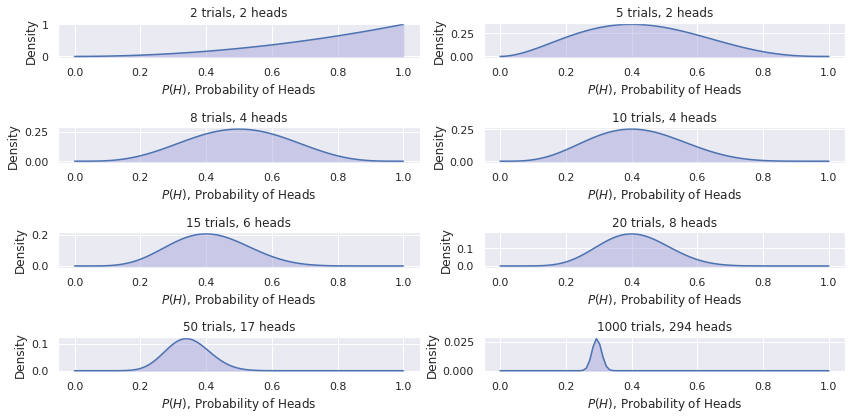

In [ ]:

from functools import partial
# Discretise the x-axis into 100 separate plotting points
thetas = np.linspace(0, 1, 100)

# Loops over the number_of_trials list to continually add
# more coin toss data. For each new set of data, we calculate
# the new likelihood based on the binomial distribution.
# That is, we are given count and N for the sampling
# count ~ Binom(N, p); we then back out what the likely values of p are
for i, N in enumerate(number_of_trials):
    # Step 2: Observe some proportion of the trials
    # Accumulate the total number of heads for this 
    # particular Bayesian update
    heads = data[:N].sum()

    ax = plt.subplot(len(number_of_trials) / 2, 2, i + 1)
    ax.set_title("%s trials, %s heads" % (N, heads))
    plt.xlabel("$P(H)$, Probability of Heads")
    plt.ylabel("Density")
            
    # Step 3: Plot the likelihood of observing the data as a function of the coin's bias
    # Calculate the binomial probability mass function for each possible
    # theta under consideration for our given experiment
    f = partial(stats.binom.pmf, heads, N)
    y = np.apply_along_axis(f, 0, thetas)

    plt.plot(x, y, label="observe %d tosses,\n %d heads" % (N, heads))
    plt.fill_between(x, 0, y, color="#aaaadd", alpha=0.5)


# Expand plot to cover full width/height and show it
plt.tight_layout()

We have plotted the likelihood of the coins bias as a function of the amount of data we've observed. Even when applying Bayesian inference, as the number of datapoints you observe increases to infinity, the frequentist and bayesian estimates converge. That is, the probability distribution returned by bayesian inference converges to a dirac delta function centered at the frequentist point estimate. This makes sense: if we have infinite evidence, our prior beliefs shouldn't matter - the evidence outweighs any prior beliefs we've had. We can see this effect in the plots above, with the distributions tighetining as the number of trials increases.

#### Difference between frequentist and bayesian interpretations

The above analysis is valid for both bayesian and frequentist practices. However, the two statisticians would interpret the data differently. When asked "what is the bias of the coin?" the frequentist would use the Maximum Likelihood Estimate (MLE). They would look at the distribution, check the highest point, and return the point estimate based off that mode. The bayesian however, would answer that the bias of the coin is *the entire distribution*. They recognize the coin bias could be a range of values, with different credibilities based off the observed data.   

### Incorporating a Prior

How does all this change when inorporating a prior? Let's first rewrite out Bayes theorem using the names of the components we discussed earlier.

$$ P(\text{Posterior}) = \frac{ P(\text{Likelihood}) P(\text{Prior}) } {P(\text{Evidence}) } $$

Our goal is to evaluate the posterior distribution of the likely coin biases. Let's think through each of these components. 

We've just seen how we can calculate the **likelihood** - this is our standard calculation shared by both frequentist and bayesian inference. For the likelihood, we use the evidence we've observed and consider what range of parameters would have been most likely to produce the results, given the evidence. In our example, we calculated this by using the PMF of the binomial distribtuion across all the possible coin biases considered. 

For the **prior**, well, we specify this ourselves! So we don't need to do any calculations, it's just our beliefs we have coming in. Our only constrainsts are that our priors must be valid probability distributions (PDF integrates to 1). We'll discuss choosing smart priors later. For now, it's enough to know we'll choose a probability distribution to represent our priors. 

And now, we are left with the pesky denominator. The **evidence.** The probability distribution of the evidence is notoriously difficult to calculate, and the difficulty of calculating this distribution is the motivation for computational techniques such as Markov Chain Monte Carlo and Variational Inference. What is the probability of seeing X heads, given that we don't know the underlying bias of the coin? To achieve this, we need to consider *all possible coin biases* (all our possible hypotheses), calculate the probability that we would have seen X heads under that hypothesis, and then sum up all those possibile universes. As we mentioned before, the evidence is a *normalizing factor* which ensures our posterior is a valid probability distribution. 

Let's rewrite our Bayesian inference formula:

$$P(\theta|X) = \frac{\mathcal{L}(X|\theta)P(\theta)}{\int\limits_0^1 \mathcal{L}(X|\theta)P(\theta)d\theta}$$

We see that we've replaced the denominator with the mathematical representation for our explanation above. We **integrate out the dependence on theta** (our hypothesis, the bias of the coin in our example) by considering all possible thetas. In most real life applications, this amounts to solving a horrifically complex multiple integral (one integration for each free parameter), and is intractable in all but the simplest cases.

In our coin flip example, we can approximate this integration with discrete calculations since we only have one free parameter (this approach grows exponentially with the number of free parameters since we're discretizing multidimensional space which is $O(C^n)$. As such, it is computationally intractable for all but trivial models like this one). We simply multiply each hypothesis' likilihood by its prior PDF and sum. This way, we normalize for all possible outcomes. 

We now have the tools at our disposal to complete our Bayesian inference. All that's left is to choose a prior distribution.

We will use a beta distribution as our prior. The beta distribution is a good choice when we want to model the probability that some event will occur, because it can naturally assume values between 0 and 1. We know that most coins are fair, so we will center our estimate around 0.5. We also know that we are dealing with a shady individual, and so we won't choose a prior which is too narrow - this will make it difficult to update our hypothesis about the fairness of the coin as we gather more data.

We can think of using a wide distribution as having an open mind. The width of our prior distribution can also be seen as having a regularizing effect - the narrower our prior (the more convicion we have in our belief), the more evidence is needed to change our mind. That is, a narrower prior provides a stronger regularizing force. On the flipside, a wide prior will cause us to fit our posterior estimate much more closely to the data.

In [ ]:
# Define a function so we can play with our parameters
def calculate_posterior(a, b, n=10):
    """Calculates the posterior for a given parameterization of the beta prior
    
    Args:
        a: the alpha parameter in the beta dist
        b: the beta parameter in the beta dist
        n: the number of coin flip samples to observe
        
    Returns:
        The posterior distribution after performing Bayesian inference
    """
    f = partial(stats.binom.pmf, data[:n].sum(), n)
    theta_likelihood = np.apply_along_axis(f, 0, thetas)
    # Probability density function for all thetas under consideration. This is our prior
    # for what we believe the coins bias could be
    p_theta = stats.beta.pdf(thetas, a,b)
    # Normalize p_theta so we're dealing with probabilities
    p_theta = (p_theta / p_theta.sum())
    # Probability of seeing the data is our confidence in the theta from our prior
    # multiplied by the likelihood that each theta could have generated the data,
    # integrated over all possible thetas under consideration. This is the 
    # demoninator of the equation above
    p_data = (theta_likelihood * p_theta).sum()

    # our updated posterior is the likelihood that the data was generated by a 
    # given theta, times our prior belief in the chance that that theta was used,
    # normalized by the sum of the possibilities that we've considered 
    p_theta_given_data = (theta_likelihood * p_theta) / p_data
    df_posterior = pd.DataFrame(index=thetas).assign(likelihood=theta_likelihood/theta_likelihood.sum(),
                                                 prior=p_theta, posterior=p_theta_given_data)
    return df_posterior


Observed 4 heads


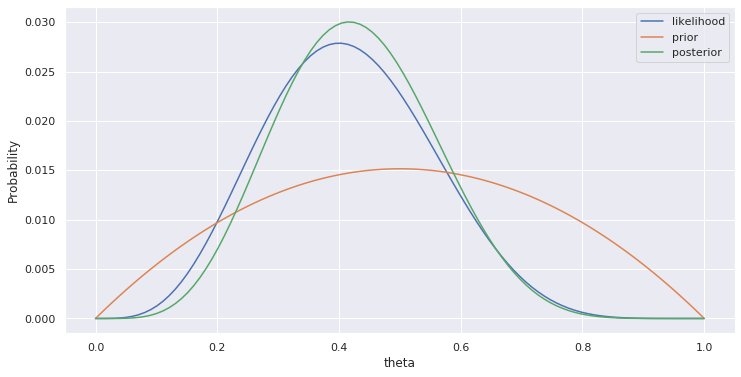

In [ ]:
df_posterior = calculate_posterior(2, 2)
print(f'Observed {data[:10].sum()} heads')
df_posterior.plot()
plt.ylabel('Probability')
plt.xlabel('theta');

Let's look at the impact of a strong prior on our posterior. We start with the widest prior -- a uniform distrubution, and find that our posterior distribution is exactly equal to our likelihood. As we add more conviction that the coin is fair (narrow our prior distribution around 0.5) we see a greater regularizing effect and the resultant posterior does not move as much towards the sample likelihood

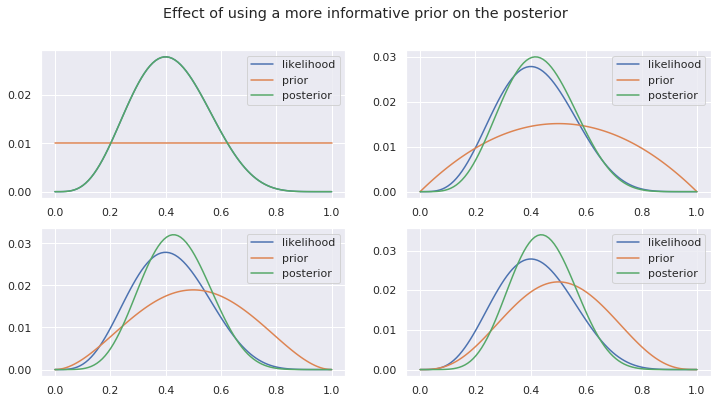

In [ ]:
for i in range(1,5):
    ax = plt.subplot(2,2,i)
    df_posterior = calculate_posterior(i, i)
    #df_posterior = pd.DataFrame(index=thetas).assign(prior=p_theta, posterior=p_theta_given_data)
    df_posterior.plot(ax=ax)
plt.suptitle('Effect of using a more informative prior on the posterior');

What about the impact of observing more data points on our posterior?


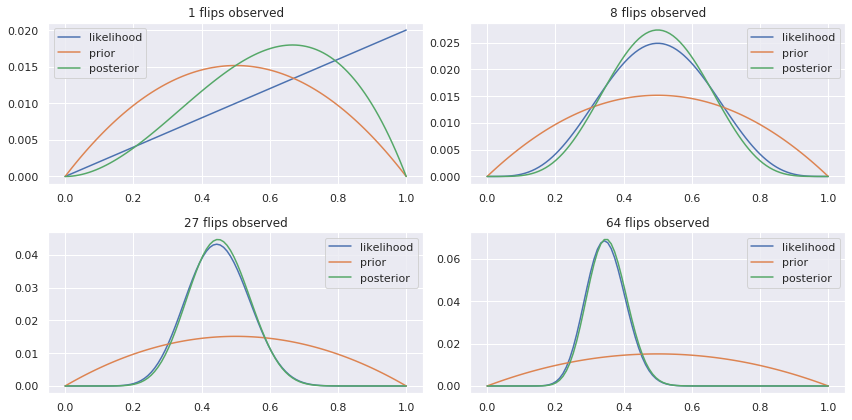

In [ ]:
for i in range(1,5):
    ax = plt.subplot(2,2,i)
    df_posterior = calculate_posterior(2, 2, i**3)
    #df_posterior = pd.DataFrame(index=thetas).assign(prior=p_theta, posterior=p_theta_given_data)
    df_posterior.plot(ax=ax)
    ax.set_title(f'{i**3} flips observed')

plt.tight_layout()

We can see that as we observe more datapoints, the likelihood and posterior converge as the prior has less and less influece.

## Conclusion

In this workbook, we've learned about

- The power of the Data Generation Process
    - Combining the DGP and Bayesian Inference to create powerful and explainable models
- Understanding Generative vs Discriminative Models
    - Modelling P(x,y) vs P(y|x)
    - Specifying how the data is actually created vs defining the separation between instances
    - Pros and cons, including the accuracy of disciminative models vs the interpretability and flexibility of generative models
- Understanding the constituents of Bayes Theorem
    - The prior, likihood, evidence and posterior
- Performing Bayesian Inference by hand
    - Calculting the likihood
    - Choosing a prior
    - Integrating out the denominator
    
    
With this, we've walked through the nuts and bolts of Bayesian Inference, seen it in practice combined with the power of a Data Generation Process and learned the foundations of the powerful tools of Marokov Chain Monte Carlo and Variational Inference.

### References

1. [Bayesian Methods for Hackers]()
2. [PyMC3](https://docs.pymc.io/)
3. [A Students Guide to Bayesian Analysis](https://www.amazon.ca/STUDENTS-GUIDE-BAYESIAN-STATISTICS/dp/1473916364)
4. [Build Facebooks Prophet in PyMC3](https://www.ritchievink.com/blog/2018/10/09/build-facebooks-prophet-in-pymc3-bayesian-time-series-analyis-with-generalized-additive-models/)